In [1]:
import math
import timeit

import numpy as np
from pymoo.problems import get_problem
from pymoo.visualization.scatter import Scatter
from tqdm import tqdm

from archive import dominates

In [2]:
def seq_search(solution, F):
    """
    Sequential search strategy for ens_ss() algorithm.

    :param solution:
    :param F:
    :return:
    """
    for k in range(len(F)):
        for entry in F[k]:
            if dominates(entry['fit'], solution):
                break
        else:
            return k
    return len(F)


In [3]:
def ens_ss(pop, fit, vel):
    """
    Efficient non-dominated sort (sequential search variant), as discussed in:
    Zhang, Xingyi, et al.
    "An efficient approach to nondominated sorting for evolutionary multiobjective optimization."
    IEEE Transactions on Evolutionary Computation 19.2 (2014): 201-213.

    :param pop: The population.
    :param fit: Fitness of the population.
    :return: Set of fronts
    """
    F = []  # set of fronts

    # Sort pop in ascending order by first objective
    sorted_idxs = fit[:, 0].argsort(axis=0)
    fit = fit[sorted_idxs]
    pop = pop[sorted_idxs]

    for i in range(fit.shape[0]):
        k = seq_search(fit[i], F)
        if k == len(F):
            F.append([])
        F[k].append({'pos': pop[i].copy(), 'fit': fit[i].copy(), 'vel': vel[i].copy()})

    return F


In [4]:
def crowding_distance(front):
    """
    Calculates the crowding distance from the provided front

    :return: Crowding distances
    """
    for solution in front:
        solution['dist'] = 0

    num_of_objectives = len(front[0]['fit'])
    for i in range(num_of_objectives):
        front.sort(key=lambda x: x['fit'][i])
        for j in range(1, len(front) - 1):
            front[j]['dist'] += front[j + 1]['fit'][i] - front[j - 1]['fit'][i]
        front[0]['dist'] = math.inf
        front[-1]['dist'] = math.inf

    return front

In [5]:
def CMOPSO(problem, low_bound, high_bound, max_iter, pop_size, gamma, T_a):
    # T_a is maximum age before particle position is re-initialized
    # Age increases by one each time fitness isn't improved an iteration
    # gamma is size of elite particle set
    positions = np.random.uniform(low_bound, high_bound, size=(pop_size, problem.n_var))
    velocities = np.zeros(shape=(pop_size, problem.n_var))
    fitnesses = problem.evaluate(positions)
    age = np.full(fill_value=0, shape=(pop_size, 1))

    for _ in tqdm(range(max_iter)):
        ##############################
        # Competition-based learning #
        ##############################

        # Select elite particles from P according to front index and crowding distance
        # Remember: gamma is size of elite container
        F = ens_ss(positions, fitnesses, velocities)  # non-dominated sorting
        front_sum = 0
        L = []  # elite particle container
        for i in range(len(F)):
            len_front = len(F[i])
            if len_front + front_sum < gamma:
                L += F[i]
                front_sum += len_front
            elif len_front + front_sum >= gamma:
                # Crowding distance calculations determine the particles that are kept
                F[i] = crowding_distance(F[i])
                F[i].sort(key=lambda x: x['dist'], reverse=True)
                L += F[i][0:gamma - front_sum]
                break

        L_pos = np.array([entry['pos'] for entry in L])
        L_fit = np.array([entry['fit'] for entry in L])

        # Randomly choose 2 elite particles from L for each particle
        rand_elite_idxs = np.random.randint(0, len(L), size=(pop_size, 2))
        rand_elite = L_fit[rand_elite_idxs]
        rand_elite_pos = L_pos[rand_elite_idxs]

        # Calculating angles (https://stackoverflow.com/a/13849249)
        norm_rand_elite = np.linalg.norm(rand_elite, axis=2).reshape((-1, 2, 1))
        norm_fitnesses = np.linalg.norm(fitnesses, axis=1).reshape(-1, 1)

        unit_vector_fitnesses = fitnesses / norm_fitnesses
        unit_vector_rand_elite = rand_elite / norm_rand_elite

        split_rand_elite = np.split(unit_vector_rand_elite, 2, axis=1)
        for i in range(len(split_rand_elite)):
            split_rand_elite[i] = split_rand_elite[i].reshape(-1, 2)

        # The angles between random elites and fitnesses
        # 'ij,ji->i' grabs only the elements on the diagonal of the matrix multiplication
        # arccos then calculates the angle, where values must be clipped between -1 to 1
        theta_1 = np.arccos(
            np.clip(np.einsum('ij,ji->i', split_rand_elite[0], unit_vector_fitnesses.transpose()), -1.0, 1.0))
        theta_2 = np.arccos(
            np.clip(np.einsum('ij,ji->i', split_rand_elite[1], unit_vector_fitnesses.transpose()), -1.0, 1.0))
        p_w = np.concatenate((rand_elite_pos[theta_1 < theta_2, 0, :], rand_elite_pos[theta_1 >= theta_2, 1, :]))

        # Update positions and velocities
        r_1 = np.random.uniform(0.0, 1.0, size=(pop_size, problem.n_var))
        r_2 = np.random.uniform(0.0, 1.0, size=(pop_size, problem.n_var))

        new_velocities = r_1 * velocities + r_2 * (p_w - positions)
        new_positions = positions + velocities
        new_fitnesses = problem.evaluate(new_positions)

        #######################
        # Polynomial Mutation #
        #######################
        # Using the technique explained in:
        # Zapotecas Martínez, Saúl, and Carlos A. Coello Coello.
        # "A multi-objective particle swarm optimizer based on decomposition."
        # Proceedings of the 13th annual conference on Genetic and evolutionary computation. 2011.
        '''
        # Update ages of particles
        improved_fitness = (new_fitnesses >= fitnesses).all(axis=1)
        age[np.logical_not(improved_fitness)] += 1
        age[improved_fitness] = 0

        expired_ages = np.where(age >= T_a)[0]
        new_positions[expired_ages] = np.clip(np.random.normal((new_positions[expired_ages] - p_w[expired_ages]) / 2,
                                                              np.abs(new_positions[expired_ages] - p_w[expired_ages])), 0, 1)
        new_fitnesses[expired_ages] = problem.evaluate(new_positions[expired_ages])
        new_velocities[expired_ages] = np.full(fill_value=0.0, shape=new_velocities[expired_ages].shape)
        '''
        ###########################
        # Environmental Selection #
        ###########################

        # Calculate the non-dominated in new positions
        all_positions = np.concatenate((positions, new_positions), axis=0)
        all_fitnesses = np.concatenate((fitnesses, new_fitnesses), axis=0)
        all_velocities = np.concatenate((velocities, new_velocities), axis=0)
        all_F = ens_ss(all_positions, all_fitnesses, all_velocities)
        L = []  # elite particle container
        for i in range(len(all_F)):
            len_front = len(F[i])
            if len_front + front_sum < pop_size:
                L += F[i]
                front_sum += len_front
            elif len_front + front_sum >= pop_size:
                # Crowding distance calculations determine the particles that are kept
                F[i] = crowding_distance(F[i])
                F[i].sort(key=lambda x: x['dist'], reverse=True)
                L += F[i][0:pop_size - front_sum]
                break
        positions = np.array([entry['pos'] for entry in L])
        fitnesses = np.array([entry['fit'] for entry in L])
        velocities = np.array([entry['vel'] for entry in L])
    return fitnesses


In [6]:
np.seterr('raise')  # Used for debugging.
problem = get_problem("zdt1")
# Must change the problem to -f(x) since CMOPSO assumes maximization.
tmp = problem.evaluate
problem.evaluate = lambda x: -1 * tmp(x)

fitnesses = CMOPSO(problem, 0.0, 1.0, 100, 100, 10, 25)

100%|██████████| 100/100 [00:00<00:00, 138.72it/s]


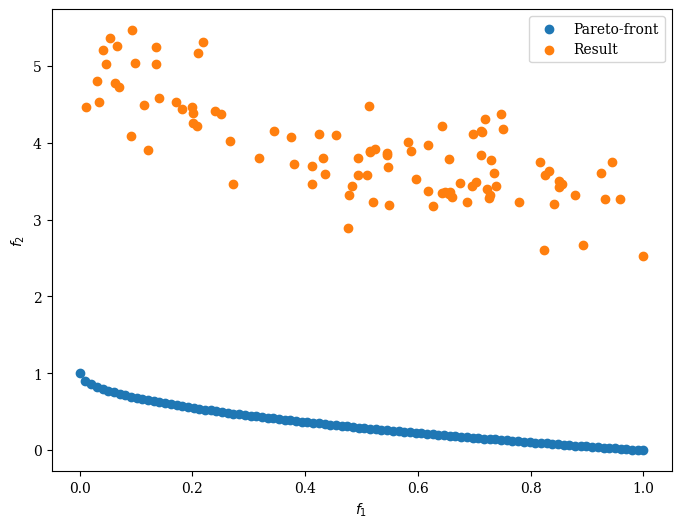

In [7]:
pf = problem.pareto_front()
Scatter(legend=True).add(pf, label="Pareto-front").add(fitnesses * -1, label="Result").show()